In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import solve_ivp
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

referenced from orbital dynamics webpage

In [35]:
G = 6.67430e-20  # km**3/(kg * s**2)
m_1 = m_2 = ((4e8 * u.Msun).to(u.kg)).value  # kg
dist = (215 * u.pc).to(u.km).value
v_circ = np.sqrt((G*m_1*dist)/(dist*2)**2)
print(v_circ)
R_1_0 = np.array((dist, 0, 0))  # km
R_2_0 = np.array((-dist, 0, 0))  # km
dotR_1_0 = np.array((0,v_circ, 0))  # km/s
dotR_2_0 = np.array((0, -v_circ, 0))  # km/s

y_0 = np.hstack((R_1_0, R_2_0, dotR_1_0, dotR_2_0))

print(y_0)

44.72612924484051
[ 6.63420680e+15  0.00000000e+00  0.00000000e+00 -6.63420680e+15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.47261292e+01
  0.00000000e+00  0.00000000e+00 -4.47261292e+01  0.00000000e+00]


In [36]:
def absolute_motion(t, y):
    """Calculate the motion of a two-body system in an inertial reference frame.

    The state vector ``y`` should be in the order:

    1. Coordinates of $m_1$
    2. Coordinates of $m_2$
    3. Velocity components of $m_1$
    4. Velocity components of $m_2$
    """
    # Get the six coordinates for m_1 and m_2 from the state vector
    R_1 = y[:3]
    R_2 = y[3:6]

    # Fill the derivative vector with zeros
    ydot = np.zeros_like(y)

    # Set the first 6 elements of the derivative equal to the last
    # 6 elements of the state vector, which are the velocities
    ydot[:6] = y[6:]

    # Calculate the acceleration terms and fill them in to the rest
    # of the derivative array
    r = np.sqrt(np.sum(np.square(R_2 - R_1)))
    ddot = G * (R_2 - R_1) / r**3
    ddotR_1 = m_2 * ddot
    ddotR_2 = -m_1 * ddot

    ydot[6:9] = ddotR_1
    ydot[9:] = ddotR_2
    return ydot

In [37]:
int((1400 * u.yr).to(u.s).value)

44180640000

In [38]:
t_0 = 0  # seconds
t_f = int(((13 * u.Myr).to(u.s)).value) # seconds
t_points = np.linspace(t_0, t_f, 5000)

print(t_points)

sol = solve_ivp(absolute_motion, [t_0, t_f], y_0, t_eval=t_points, rtol=1e-8, atol=1e-8)

y = sol.y.T
R_1 = y[:, :3]  # km
R_2 = y[:, 3:6]  # km
V_1 = y[:, 6:9]  # km/s
V_2 = y[:, 9:]  # km/s
barycenter = (m_1 * R_1 + m_2 * R_2) / (m_1 + m_2)  # km

print(f'Printing barycenter: {barycenter}')

[0.00000000e+00 8.20661732e+10 1.64132346e+11 ... 4.10084668e+14
 4.10166734e+14 4.10248800e+14]
Printing barycenter: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


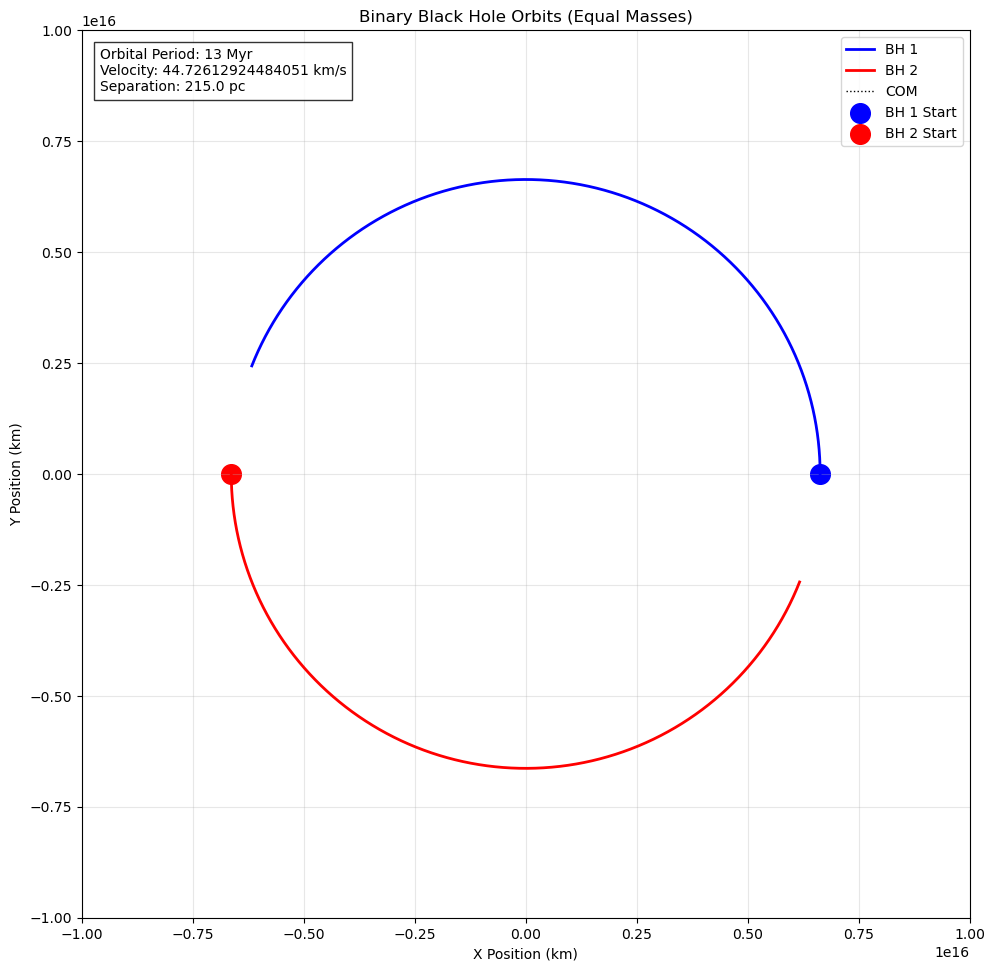

In [39]:
plt.figure(figsize=(10, 10))  # Square figure

# Plot orbits with consistent line styles
plt.plot(R_1[:, 0], R_1[:, 1], 'b-', linewidth=2, label='BH 1')
plt.plot(R_2[:, 0], R_2[:, 1], 'r-', linewidth=2, label='BH 2')
plt.plot(barycenter[:, 0], barycenter[:, 1], 'k:', linewidth=1, label='COM')

# Mark initial positions
plt.scatter(R_1_0[0], R_1_0[1], color='blue', s=200, marker='o', label='BH 1 Start')
plt.scatter(R_2_0[0], R_2_0[1], color='red', s=200, marker='o', label='BH 2 Start')

# Equal aspect ratio with manual limits
max_extent = max(np.abs(R_1).max(), np.abs(R_2).max())
plt.xlim(-10e15, 10e15)
plt.ylim(-10e15, 10e15)
plt.gca().set_aspect('equal')

# Physical validation text
period = 13  # Myr
plt.text(0.02, 0.98, 
         f"Orbital Period: {period} Myr\n"
         f"Velocity: {v_circ} km/s\n"
         f"Separation: {dist/3.086e13:.1f} pc",
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('X Position (km)')
plt.ylabel('Y Position (km)')
plt.title('Binary Black Hole Orbits (Equal Masses)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()